# Person - anomaly detection in hourly Object Counts

In this Notebook I will identify unusually high count of objects in a given hour for a predicted object class (like Person, Car, cat, etc.).

This anomaly detection can be run in real time on invidual frames while objects are detected from the video stream.

If we already know the forecast for a given hour (let's say 3 objects) then we compare a number of already registered objects (let's say 6) and we use some kind of treshold to classify the count as anomalous.

This challenge forms a univariate outlier detection problem, which tends be often solved by statistical methods, like:
- **IQR** with $lowerBound=Q1-(IQR*1.5)$ and $upperBound=Q3+(IQR*1.5)$, where $IQR=Q3-Q1$
- **Z-Score** with $zScore_i=(x_i-\mu)\div\sigma$, where $x_i$ is an i-th data point, $\mu$ and $\sigma$ are a sample arithmetic mean and standard deviation respectively

As we will determine in **Section 2 Quick data analysis**, the 2 methods above generate many False Positives due to the skewness in the dataset ([2008 Hubert et al.](https://wis.kuleuven.be/stat/robust/papers/2008/adjboxplot-revision.pdf)) and therefore 2 additional solutions will be proposed and analysed:
- **Adjusted Boxplot** with skewness parameter $MC$
- **Probabilistic Programming** with estimation of $\mu$ through sampling from a Poisson distribution

In [180]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [181]:
# import ConfigImports Notebook to import and configure libs
%run ../ConfigImports.ipynb

TF -> Using GPU ->  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Load, process and clean up the dataset

Here I am loading the unique hourly observation counts. Taking a look at the first few records, we can see the data shape and format below:

In [182]:
df = pd.read_csv('../Datasets/UniqueObjectDetections__person__2019-09-09_2020-03-02.csv')
print(df.shape)
df.head(2)

(4790, 26)


,img_idx,label,confidence,x1,y1,x2,y2,date,time,filename,img_n_boxes,time_ms,date_time,week_day,is_weekend,month,hour,min,dummy_var,time_diff,sec_diff,x_center,y_center,prev_x_center,prev_y_center,euc_distance
0,73740,person,0.450496,459,24,478,38,2019-09-09,07.03.03,07.03.03.965_4d9909b4_person-car-car-car.jpg,2,965,2019-09-09 07:03:03.965,Monday,False,9,7,3,1,0 days 00:42:40.471000000,2560.471,468.5,31.0,490.0,310.0,279.827179
1,73135,person,0.658724,286,238,381,340,2019-09-09,07.29.50,07.29.50.440_4e0ee29d_person-car-car.jpg,1,440,2019-09-09 07:29:50.440,Monday,False,9,7,29,1,0 days 00:26:46.475000000,1606.475,333.5,289.0,468.5,31.0,291.185508


Next usual step is to make sure that the DateTime fields are converted using Pandas `to_datetime` function, so Pandas can support the next operations.

In [183]:
# make sure Pandas understands date time fields
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = pd.to_datetime(df['date'])

Now we can resample the data by hour.

This is required as currently the dataset has gaps in ours without any observations, but we want to fill these gaps with zeros, so the dataset is continous and consistent (each day should represent 24 records).

In [184]:
# use Pandas handy resample feature to fill in gaps with 0's
resampled_clean = df.set_index('date_time').resample('H')['dummy_var'].sum().reset_index()
resampled_clean.columns = ['date_time', 'obs_count']
resampled_clean['date'] = resampled_clean['date_time'].dt.date.astype(str)
resampled_clean['hour'] = resampled_clean['date_time'].dt.hour
resampled_clean = resampled_clean[['date', 'hour', 'obs_count']]

Now we need to remove all observations for the downtime days (this occurred during power outages and when disk ran out of space)

In [185]:
# remove any entries where we know that there was an error in measurements
orig_size = resampled_clean.shape[0]
idx = resampled_clean['date'].isin(['2020-01-13', '2020-01-14', '2020-02-28'])
resampled_clean = resampled_clean.loc[~idx]
print(f'Removed {orig_size - resampled_clean.shape[0]} records')

Removed 72 records


Here are a few samples from the prepared dataset:

In [186]:
resampled_clean.head(2)

,date,hour,obs_count
0,2019-09-09,7,2
1,2019-09-09,8,3


### Quick data analysis

Before we dive into the outlier detection methods, we can take a look at the dataset.

We are analysing the `obs_count` feature, which is a target value, counting historically objects detected in a given date and hour.

To see an overall distribution of counts, we can plot a histogram:

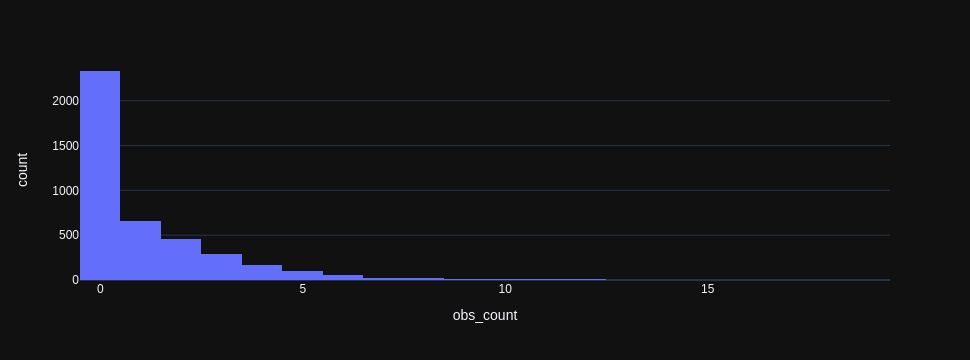

In [124]:
px.histogram(resampled_clean, x="obs_count", height=300, width=600, nbins=20)

Overall this data is heavily skewed towards 0's, but this is expected. During the night or when it's dark, the number of objects will be zero and we are not using a night vision camera, and in some time periods there is just not much activity happening.

Next, we can calculate the standard statistical metrics: arithmetic mean ($\mu$) and standard deviation ($\sigma$) for this data grouped by hour.

In [125]:
# group by hour and generate stats at that level
grouped = resampled_clean.groupby('hour')['obs_count']
stats = grouped.agg(['mean', 'std']).reset_index()

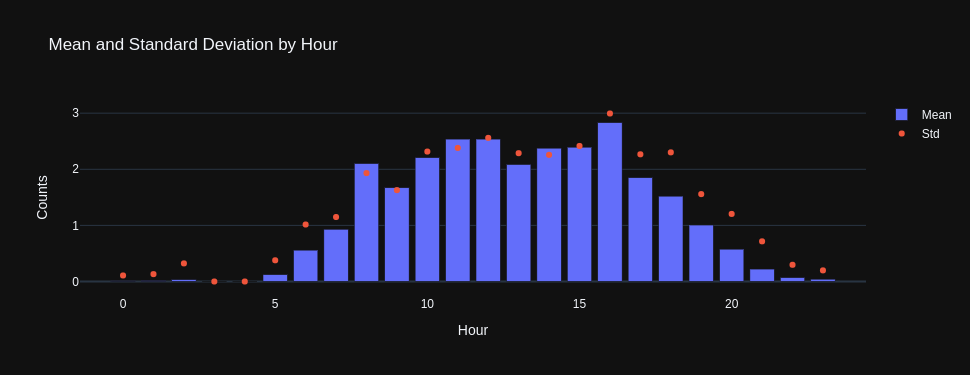

In [126]:
# construct the multi scatter plot
fig = go.Figure()
fig.add_trace(go.Bar(x=stats['hour'], y=stats['mean'], name='Mean'))
fig.add_trace(go.Scatter(x=stats['hour'], y=stats['std'], name='Std', mode='markers'))
fig.update_layout(title='Mean and Standard Deviation by Hour', height=375, width=800, xaxis_title="Hour", yaxis_title="Counts")
fig.show()

As we can see, the means follow a Normal distribution with a quite large spread between the values for each hour.

We can say that the $\mu$ matches the $\sigma$ values roughly.

This is however a very misleading picture of this dataset as it is affected by the outliers hidden inside these numbers.

In reality, if we take a look at hours during the day, the picture looks very different, below is a plot from 9AM to 4PM across the whole dataset:

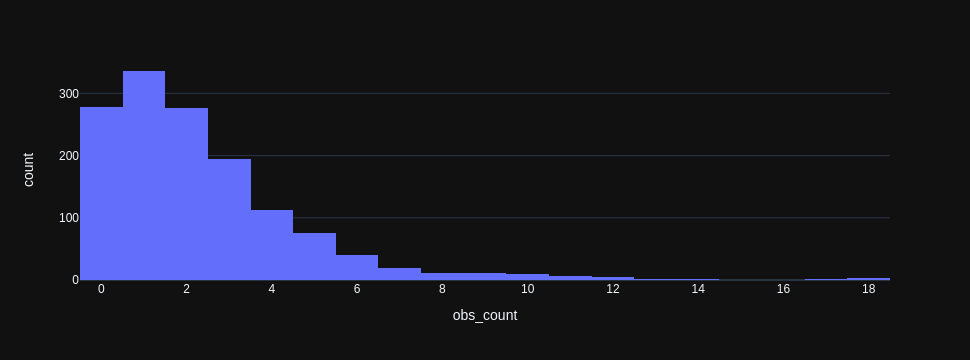

In [221]:
resampled_clean_filtered = resampled_clean[resampled_clean['hour'].isin([9,10,11,12,13,14,15,16])]
px.histogram(resampled_clean_filtered, x="obs_count", height=300, width=600, nbins=20)

Since every hour will have it's own characteristics, in order to identify anomalies for a given hour, we should analyse each hour individually and somehow calculate the thresholds above which a data point will be classfied as anomalous.

A standard step in the data analysis is to draw a boxplot, which actually uses **IQR** to identify outliers. This is done in the following plot:

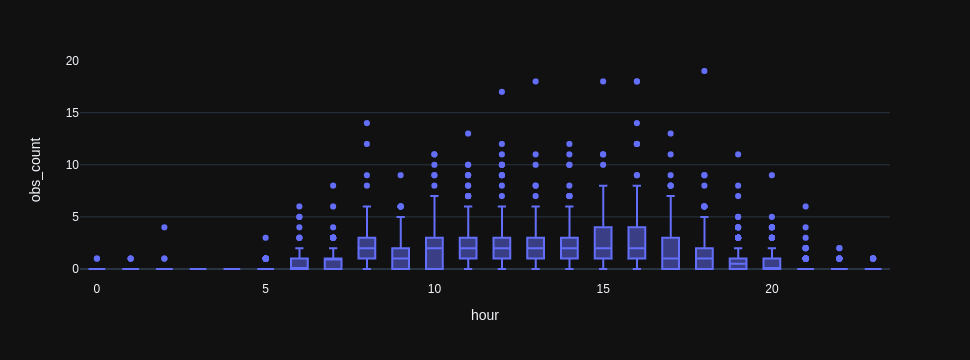

In [128]:
# create a box plot of counts for each hour
px.box(resampled, x="hour", y="obs_count", height=300, width=900)

We see straight away that too many points are classified as outliers, and we need to start changing the logic of the standard IQR approach in order to make the algorithm more relaxed.

### IQR

We can calculate analytically the percentage of observations registered by the IQR method:

In [164]:
# create a copy of the dataframe not to polute the original one
resampled = resampled_clean.copy()

def find_outlier_params(df_in, col_name, iqr_multiplier=1.5):
    """Calculate outliers based on the interquartile range (IQR)"""
    q1, q3 = df_in[col_name].quantile(0.25), df_in[col_name].quantile(0.75)  # first and third quartiles
    iqr = q3 - q1  # interquartile range
    fence_low, fence_high = q1 - iqr_multiplier * iqr, q3 + iqr_multiplier * iqr  # lower and upper bounds
    return iqr, fence_low, fence_high

# find upper fence for each hour (we don't need the lower fence any more)
grouped = resampled_clean.groupby('hour')['obs_count']
for name, group in grouped:
    g = pd.DataFrame(group)
    iqr, fence_low, fence_high = find_outlier_params(g, 'obs_count')
    idx = resampled['hour'] == name
    resampled.loc[idx, 'iqr'] = iqr
    resampled.loc[idx, 'fence_high'] = fence_high

# identify outliers using the calculation mentioned above
n_outliers = resampled[resampled['obs_count'] > resampled['fence_high']].shape[0]
print(f'{n_outliers} outliers detected, {round(n_outliers / resampled.shape[0], 2) * 100}% of the dataset')

206 outliers detected, 5.0% of the dataset


5% of the dataset is definitely too high, therefore the vanila IQR approach is not good enough.

### Z-Score

As an alternative, we can take a look at the **Z-Score** measure and see the outliers identified by this method.

In [130]:
# create a copy of the dataframe not to polute the original one
resampled = resampled_clean.copy()

# add statistics to the dataset for easier calculations
resampled['mean'] = resampled['hour'].map(stats.set_index('hour')['mean'])
resampled['std'] = resampled['hour'].map(stats.set_index('hour')['std'])
resampled['zscore'] = (resampled['obs_count'] - resampled['mean']) / resampled['std']

# identify outliers using the calculation mentioned above

ANOM_THRESHOLD = 3
n_outliers = resampled[resampled['zscore'] > ANOM_THRESHOLD].shape[0]
print(f'{n_outliers} outliers detected, {round(n_outliers / resampled.shape[0], 2) * 100}% of the dataset')

75 outliers detected, 2.0% of the dataset


Even though this looks better, it is a well known problem (TODO: provide resource) that Z-Score suffers from a similar problem as IQR and tends to generate False Positive results in skewed datasets.

### Adjusted boxplot for skewed distributions

In the 2008's [paper](https://wis.kuleuven.be/stat/robust/papers/2008/adjboxplot-revision.pdf) by M. Hubert et al., an alternative method has been proposed to IQR: *An Adjusted Boxplot for Skewed
Distributions*.

The first step is to actually calculate the skewness of the dataset. It is achieved using the equation below:

$$QS = \frac{(Q3 − Q2) − (Q2 − Q1)}{Q3 − Q1}$$

The measure is called the *medcouple (MC)* and the result is a range is between -1.0 and 1.0, where value close to 1.0 represents skew distributed to the right and -1.0 to the left respectively.

An advanced version of this (efficient and dealing with edge cases) is available in `statsmodels` package. We can calculate an example `mc` for **4PM** data:

In [239]:
from statsmodels.stats.stattools import medcouple

filtered = resampled_clean[resampled_clean['hour'] == 16]
mc = medcouple(filtered['obs_count'].values).tolist()
print(f'StatsModels: skewness for obs_count is {mc}')

StatsModels: skewness for obs_count is 0.3333333333333333


Then, the lower and upper bounds are calculated as follows:

$$lowerBound=Q1-h_l(MC)IQR$$
$$upperBound=Q3+h_u(MC)IQR$$

Where:

$$h_l(MC)=1.5e^{aMC}$$
$$h_u(MC)=1.5e^{bMC}$$

The authors of the paper have optimised the values for the constants $a$ and $b$ in a way that fences mark 0.7% observations as outliers.

The purpose for this was that the 0.7% percentage matches the outlier rate of a standard boxplot for symmetric distibutions.

Plugging in $-4$ and $3$ in place of $a$ and $b$ produces the following bounds:

In [241]:
q1, q2, q3 = (filtered['obs_count'].quantile(0.25), filtered['obs_count'].quantile(0.5),
              filtered['obs_count'].quantile(0.75))
a, b = -4, 3
hl, hu = 1.5*np.exp(a*mc), 1.5*np.exp(b*mc)
iqr = q3 - q1
lower_bound = q1 - hl * iqr
upper_bound = q3 + hu * iqr
print(f'Lower bound: {lower_bound}, upper bound: {upper_bound}')

Lower bound: -0.18618712152077066, upper bound: 16.232268228065703


In [242]:
# identify outliers using the calculation mentioned above
n_outliers = filtered[filtered['obs_count'] > upper_bound].shape[0]
print(f'{n_outliers} outliers detected, {round(n_outliers / filtered.shape[0], 3) * 100}% of the dataset')

2 outliers detected, 1.2% of the dataset


#### Apply to whole dataset

Now we can apply this method to the whole dataset and see how many anomalies will get detected.

In [263]:
# create a copy of the dataframe not to polute the original one
resampled = resampled_clean.copy()

def find_outlier_params_adj(df_in, col_name, a=-4, b=3):
    """Calculate outliers based on the adjusted boxplot method"""
    q1, q2, q3 = (df_in[col_name].quantile(0.25), df_in[col_name].quantile(0.5),
                  df_in[col_name].quantile(0.75))
    iqr = q3 - q1  # interquartile range
    mc = medcouple(df_in[col_name])  # medcouple skewness level, using statsmodels due to issues with IQR=0
    hl, hu = 1.5*np.exp(a*mc), 1.5*np.exp(b*mc)
    fence_low, fence_high = q1 - hl * iqr, q3 + hu * iqr
    return iqr, fence_low, fence_high, mc

# find upper fence for each hour (we don't need the lower fence any more)
grouped = resampled_clean.groupby('hour')['obs_count']
for name, group in grouped:
    g = pd.DataFrame(group)
    iqr, fence_low, fence_high, mc = find_outlier_params_adj(g, 'obs_count')
    idx = resampled['hour'] == name
    resampled.loc[idx, 'iqr'] = iqr
    resampled.loc[idx, 'mc'] = mc
    resampled.loc[idx, 'fence_high'] = fence_high

# identify outliers using the calculation mentioned above
n_outliers = resampled[resampled['obs_count'] > resampled['fence_high']].shape[0]
print(f'{n_outliers} outliers detected, {round(n_outliers / resampled.shape[0], 3) * 100}% of the dataset')

148 outliers detected, 3.5999999999999996% of the dataset


As we can see, an over 3.5% of the dataset is getting highlighted using this method.

This is only a 1.5% less than the standard IQR and 1.5% more than the Z-Score method.

This actually breaks the somewhat guaranteed maximum 0.7% anomalies for most of the distributions. I relate this issue to this particular dataset (low values may cause $IQR=0$ if $Q3=Q1$) and the `statsmodels` implementation of the `MC` algorithm sometimes returns 0 for vizually skewed distributions (example for 10AM or 3PM data subsets).

### Probabilistic Programming method

Probabilistic models utilise **Bayesian Theorem** to derive the following formula from the Conditional Probability theory:

$$P(A|B)=\frac{P(B|A)P(A)}{P(B)}$$

Where:
- $P(A|B)$ is the posterior, meaning conditional probability of event $A$ given that $B$ is true
- $P(B|A)$ is the likelyhood, also conditional probability of event $B$ ocurring given $A$ is true
- $P(A)$ is the prior (information we already know about)
- $P(B)$ is the marginal probability of observing event $B$

There are many benefits from using probabilistic modelling. Some of them are included below:
- no assumptions made about the distribution of the data
- it allows us to provide prior information to the model about distributions
- it does not require a lot of data
- it gives us the predictions and the uncertainty about them

In probabilistic programming we use the prior information we already have (like the distribution of the outcome random variable), then we define the likelyhood, which tells the library how to sample the probability space given the data, and then we perform an analysis of the posterior, which contains N-samples drawn from the distibution.

This is exactly the formula we will apply using `pymc3` Python library for probabilistic programming to create a Poisson regression process to find the means ($\mu$) and sigmas ($\sigma$) and determine the outlier criteria from the posterior.

The first task is to incorporate a prior knowledge. Below I have included a plot of the true distribution for a random few hours in the dataset and 2 types of distibutions, which will help us to model this shape:
- Half Student T distribution with parameters $\sigma=1.0$ and $\nu=1.0$ and density function:

$$f(t)=\frac{\gamma(\frac{\nu + 1}{2})}{\sqrt{\nu \pi} \Gamma (\frac{\nu}{2})} (1 + \frac{t^2}{\nu})^{-\frac{\nu + 1}{2}}$$

Where $\nu$ is the number of degrees of freedom and $\Gamma$ is the gamma function.

- Gamma distribution with parameters $\alpha=1.5$ (shape) and $\beta=0.5$ (rate) and density function:

$$f(x;\alpha;\beta)=\frac{\beta^\alpha x^{\alpha-1} e^{-\beta x}}{\Gamma(\alpha)}$$

Where $x>0$, $\alpha,\beta > 0$ and $\Gamma(\alpha)$ is the gamma function

Below is the multi-plot with both distrubutions and the true dataset with counts between 1PM and 3PM. Based on this plot we can assess which distribution is more suitable as a prior in our model.

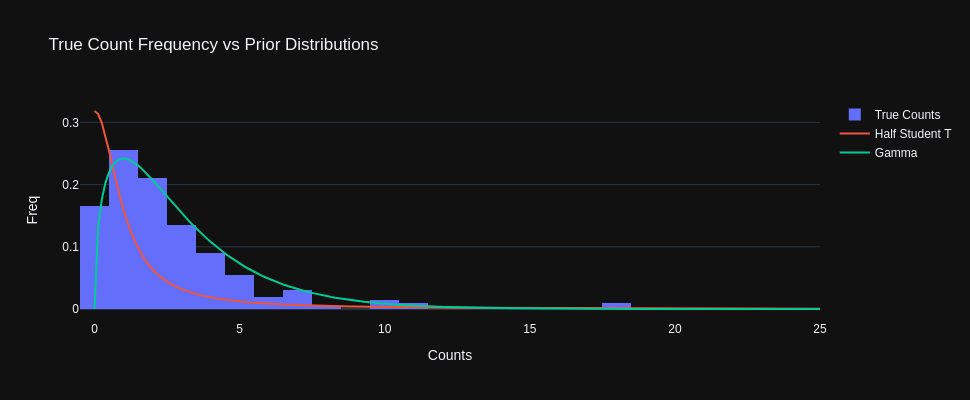

In [571]:
import scipy.stats as st

# create a copy of the dataframe not to polute the original one
resampled = resampled_clean.copy()

# define x
n_size = 200
x = np.linspace(start=0, stop=25, num=n_size)

# generate HalfStudentT data
sigma = 1.0
nu = 1.0
prior_t_pdf = st.t.pdf(x, df=nu, loc=0, scale=sigma)

# generate Gamma data
a = 1.5 # shape
b = 0.5 # rate = 1/scale
prior_g_pdf = st.gamma.pdf(x, a=a, scale=1/b)

# get sample from the data for a given hour
hours = [13,14,15]
filtered = resampled[resampled['hour'].isin(hours)].sample(n_size)
true_counts = filtered['obs_count'].values

# construct the multi scatter plot
fig = go.Figure()
fig.add_trace(go.Histogram(x=true_counts, name='True Counts', histnorm='probability'))
fig.add_trace(go.Scatter(x=x, y=prior_t_pdf, name='Half Student T'))
fig.add_trace(go.Scatter(x=x, y=prior_g_pdf, name='Gamma'))
fig.update_layout(title='True Count Frequency vs Prior Distributions', height=400, xaxis_title="Counts", yaxis_title="Freq")
fig.show()

Based on the graph above, it looks like the Gamma distibution with the parameters $\alpha=1.5$ and $\beta=0.5$ seems to be more suitable to our dataset.

The next item we need is the likelyhood function, which will be used to estimate the counts for every hour.

A suitable likelihood function will use the Poisson process.

Poisson is a discrete probability distribution, which is used when we need to model a number of event occuring in a time interval.

As per [Wikipedia article about Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution), probability mass function of $X$ for $k=0,1,2,3, ...$ is given by:

$$f(k;\lambda) = Pr(X=k) = \frac{\lambda^{k} e^{-\lambda}}{k!})$$

Where $\lambda>0$, *expected value* and *variance* are both equal to $\lambda$, e is Euler's number ($e=2.718...$) and $k!$ is the factorial of k.

The likelihood function for Poisson process is given by:

$$L(\lambda;x_1,...,x_n)=\prod^{n}_{j=1}exp(-\lambda)\frac{1}{x_j!}\lambda^{x_j}$$

As highlighted in the [online.stat.psu.edu article](https://online.stat.psu.edu/stat504/node/27/), likelihood is a tool for summarizing the data’s evidence about unknown parameters, and often (due to computational convenience), we transform the likelohood to log-likelihood.

The log-likelihood for the Poisson process is given by:

$$l(\lambda;x_1,...,x_n)=-n \lambda - \sum^n_{j=1}ln(x_j!)+ln(\lambda)\sum^n_{j=1}x_j$$

Now we can code it up using `pymc3` Python package:
- first we will define a Gamma prior (we can have a list of priors for each hour)
- then we will define a list Poisson likelihood functions for each hour
- and finally we can sample from the posterior and visualize the means for each hour

In [573]:
# import pymc3 package for probabilistic programming
import pymc3 as pm

# define a hours to analyse
analyse_hrs = [h for h in range(0, 24)]

# define dataset to use
resampled = resampled_clean.copy()
X = resampled['hour']
y = resampled['obs_count']

with pm.Model() as model:

    # Priors
    lam = [pm.Gamma(f'lambda_hour_{h}', alpha=1.5, beta=0.5) for h in analyse_hrs]
    
    # Likelihood functions for the data (for each hour)
    hrs = [pm.Poisson(f'hour_{h}', lam[i], observed=y.loc[X==h].values) for i, h in enumerate(analyse_hrs)]

    # Parameters of the simulation:
    # Number of iterations and independent chains.
    n_draws, n_chains = 2500, 3
    n_sim = n_draws * n_chains
    
    # Simulate
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=2000, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [lambda_hour_23, lambda_hour_22, lambda_hour_21, lambda_hour_20, lambda_hour_19, lambda_hour_18, lambda_hour_17, lambda_hour_16, lambda_hour_15, lambda_hour_14, lambda_hour_13, lambda_hour_12, lambda_hour_11, lambda_hour_10, lambda_hour_9, lambda_hour_8, lambda_hour_7, lambda_hour_6, lambda_hour_5, lambda_hour_4, lambda_hour_3, lambda_hour_2, lambda_hour_1, lambda_hour_0]


Now, we can only focus on a single hour to make it more readable, but the same statistics are available for each hour estimated above.

First visualization to always check is the convergence of the parameters using `pm.traceplot` method.

Below is the plot for the $\lambda$ for 4PM. What can be seen is not only the mean, but the whole distibution of means generated from all simulations:

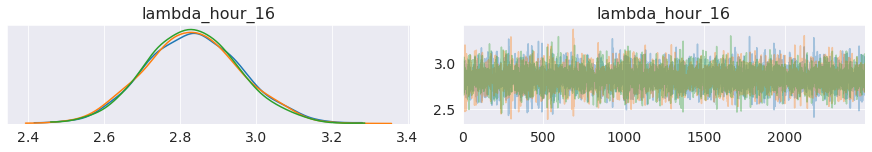

In [574]:
pm.traceplot(trace, var_names=['lambda_hour_16']);

We can ask pymc3 to calculate summary statistics analytically, which can be very useful for automation.

We can even add custom statistics to the default ones using the `stat_funcs` argument in the `pm.summary` method.

In [575]:
def median_sd(x):
    median = np.percentile(x, 50)
    sd = np.sqrt(np.mean((x-median)**2))
    return sd

func_dict = {
   "std": np.std,
   "median_std": median_sd,
   "1%": lambda x: np.percentile(x, 1),
   "median": lambda x: np.percentile(x, 50),
   "99%": lambda x: np.percentile(x, 99),
}

pm.summary(trace, var_names=['lambda_hour_16'], stat_funcs=func_dict)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,std,median_std,1%,median,99%
lambda_hour_16,2.833,0.124,2.614,3.082,0.001,0.001,17113.0,16914.0,17148.0,5415.0,1.0,0.124,0.124,2.55,2.831,3.126


Next, we want to get a little deeper into the spread of means and visualize the 99% of credible interval for means:

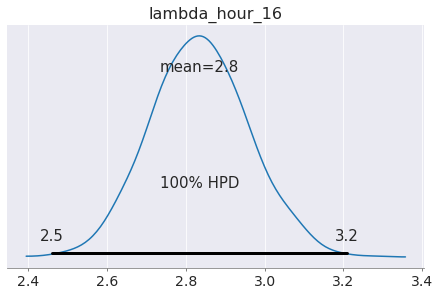

In [630]:
pm.plot_posterior(trace, var_names=['lambda_hour_16'], credible_interval=0.997);

Same can be calculated analytically:

In [631]:
pm.stats.hpd(trace['lambda_hour_16'], credible_interval=0.997)

array([2.46023178, 3.20824113])

We can even start asking questions, like:
- what is the probability for obtaining N-counts on this hour
- what is the probability for obtaining > N counts on this hour

In [582]:
# We generate n_sim samples of a Poisson distribution for
# each value for lambda_hour_16 (hour 16) simulation..
y_pred = np.random.poisson(lam=trace['lambda_hour_16'], size=n_sim)

# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(y_pred, bins=30, ax=ax)
# ax.set(title='Probability density for discrete counts at 4PM');

# Probability that we will see greate than N-observations
check_count = 8
prob = (y_pred > check_count).astype(int).mean()
print(f'Probability for obtaining greater than {check_count} counts is {prob*100}%')

Probability for obtaining greater than 8 counts is 0.33333333333333337%


And in the same way, we can ask what is count, which will report $0.7%$ as outlier (as per trend in the IQR method for normal distributions).

Any counts greater than that will be reported as outliers.

In [591]:
ANOMALY_RATE = 0.007  # give this in percentages

df = pd.DataFrame({'y_pred': y_pred})
treshold = df['y_pred'].quantile(1 - ANOMALY_RATE)  # classify % of the data as an outlier

print(f'To report {round(ANOMALY_RATE * 100, 2)}% of counts as anomalies, the upper fence is {treshold} for 4PM')

To report 0.7% of counts as anomalies, the upper fence is 8.0 for 4PM


Now we can execute the same routine across all hours, and count the number of observations classified as anomalies and set the `ANOMALY_RATE` parameter to achieve the expected result.

In [628]:
ANOMALY_RATE = 0.001

resampled = resampled_clean.copy()
resampled['fence_high'] = 0
resampled['is_anomaly'] = 'N'

for h in analyse_hrs:
    y_pred = np.random.poisson(lam=trace[f'lambda_hour_{h}'], size=n_sim)
    thresh = np.quantile(y_pred, 1 - ANOMALY_RATE)
    resampled.loc[resampled['hour'] == h, 'fence_high'] = thresh
    resampled.loc[(resampled['hour'] == h) & (resampled['obs_count'] > thresh), 'is_anomaly'] = 'Y'

n_outliers = resampled[resampled['obs_count'] > resampled['fence_high']].shape[0]
print(f'{n_outliers} outliers detected, {round(n_outliers / resampled.shape[0], 3) * 100}% of the dataset')

59 outliers detected, 1.4000000000000001% of the dataset


Now we can plot the anomaly threshold and data points to visualise if we are happy with the selected threshold:

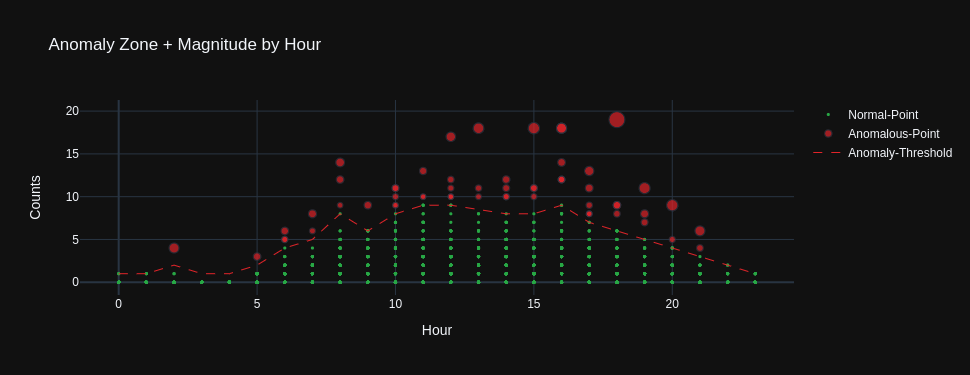

In [629]:
# Prepare data for plotting

# add a new column to represent the magnitude of an outlier
resampled['outlier_scale'] = resampled['obs_count'] / resampled['fence_high']

# select normal and anomalous slices of data
normal = resampled[resampled['is_anomaly'] == 'N']
anom = resampled[resampled['is_anomaly'] == 'Y']
# find the high fence for each hour
anom_thresh = resampled.groupby(['hour'])['fence_high'].max().reset_index()

# construct the multi scatter plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=normal['hour'], y=normal['obs_count'], name='Normal-Point', mode='markers',
                         marker=dict(color='#28a745', size=3)))
fig.add_trace(go.Scatter(x=anom['hour'], y=anom['obs_count'], name='Anomalous-Point', mode='markers',
                         marker=dict(color='#e12429', size=anom['outlier_scale'] * 5)))
fig.add_trace(go.Scatter(x=anom_thresh['hour'], y=anom_thresh['fence_high'], name='Anomaly-Threshold',
                         mode='lines', line=dict(color='#e12429', width=1, dash='dash')))
fig.update_layout(title='Anomaly Zone + Magnitude by Hour', height=375, xaxis_title="Hour", yaxis_title="Counts")
fig.show()

Now that we have the outliers identified, how could this work in real time in the actual software?

We could actually use a simple method without using any forecst information, and only compare the counts agains the fences estimated above.

TODO: Think about how the hourly forecast could be used here? Is it actually needed?

### Conclusion

TODO: add final summary about compared methods, add more plots, clean up and add more theory